# Use Numba and cython speed up Python

Numba provides a "jit" or a "just in time" compiler. Recall that C is a compiled langauge, its source code is optimized and converted to CPU instructions. Python is "interpreted," its code is NOT optimized ahead of time and is interpreted a line at a time. This means that a Python interpreter does not have enough information for optimization.

Just in time (JIT) compiler are used in many languages, including Java, C# and even Python is getting a JIT compiler in version 3.13. Numba is also a JIT addon that we can use with any version.

In [1]:
%pip install numba

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import pandas as pd
from timeit import timeit

### An implementation of K-nearest neighbors classifier
Code from perplexity.io

#### Python only

In [3]:
def euclidean_distance(p1, p2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(p1, p2)))

def knn_python(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        distances = []
        for i, train_point in enumerate(X_train):
            dist = euclidean_distance(test_point, train_point)
            distances.append((dist, y_train[i]))
        distances.sort(key=lambda x: x[0])

        nearest_labels = [label for (_, label) in distances[:k]]

        # Majority vote, manual count
        best_label = None
        best_count = 0
        for label in set(nearest_labels):
            count = nearest_labels.count(label)
            if count > best_count:
                best_count = count
                best_label = label
                
        predictions.append(best_label)
    return predictions


#### Numpy
Numpy could be much faster if it could use specialized functions in its library

In [4]:
def knn_numpy(X_train, y_train, X_test, k):
    predictions = []
    for test_point in X_test:
        # Vectorized distance calculation: array subtraction + sum of squares + sqrt
        diff = X_train - test_point  # shape (n_train, n_features)
        dists = np.sqrt(np.sum(diff ** 2, axis=1))  # shape (n_train,)

        # Convert to list of (distance, label) tuples
        distances = list(zip(dists.tolist(), y_train.tolist()))

        # Sort by distance
        distances.sort(key=lambda x: x[0])

        nearest_labels = [label for (_, label) in distances[:k]]

        # Majority vote, manual count
        best_label = None
        best_count = 0
        for label in set(nearest_labels):
            count = nearest_labels.count(label)
            if count > best_count:
                best_count = count
                best_label = label
        
        predictions.append(best_label)
    return predictions


#### Measure

In [5]:
# Some made up numbers
X_train = [[0.93588381, 0.64083873, 0.43191558],
           [0.42222037, 0.11649837, 0.06062254],
           [0.55167179, 0.92109796, 0.60461583]]
y_train = [1, 2, 3]
X_test  = [[0.35138874453456725, 0.519960657417942, 0.8637018994564011],
             [0.6558387008127351, 0.5067038567727152, 0.17407496226564068],
             [0.34327858991593596, 0.6883918432579191, 0.9240662106562946]]

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np  = np.array(y_train)

%timeit knn_python(X_train, y_train, X_test, k=2)
%timeit knn_numpy(X_train_np, y_train_np, X_test_np, k=2)

5.06 μs ± 13.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.74 μs ± 88.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Shouldn't numpy be MUCH faster than basic Python??

#### Scale matters!

In [31]:
%%time
times = []

COLUMNS = 3

for i in [3, 5, 10, 100, 500, 1_000]:
    X_train_np = np.random.rand(i, COLUMNS)
    y_train_np = np.random.randint(0, 5, size=i)  # Labels from 0 to 4
    X_test_np  = np.random.rand(i, COLUMNS)

    X_train = X_train_np.tolist()
    y_train = y_train_np.tolist()
    X_test  = X_test_np.tolist()

    python_time = timeit(lambda: knn_python(X_train, y_train, X_test, k=2), number=10)
    numpy_time  = timeit(lambda: knn_numpy(X_train_np, y_train_np, X_test_np, k=2), number=10)

    times.append((i, python_time, numpy_time))

# Pretty-print
df = pd.DataFrame(times, columns=["n_samples", "python_time", "numpy_time"])
df

CPU times: user 7.63 s, sys: 12.4 ms, total: 7.65 s
Wall time: 7.65 s


,n_samples,python_time,numpy_time
0,3,0.000304,0.000594
1,5,0.000629,0.000902
2,10,0.002267,0.001463
3,100,0.065819,0.012920
4,500,1.207252,0.277192
5,1000,4.924447,1.151940


<Axes: xlabel='n_samples'>

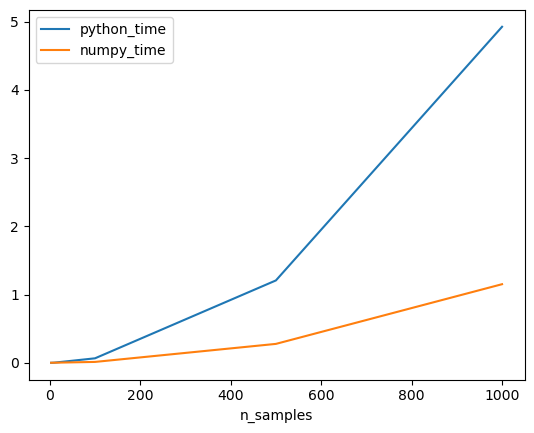

In [32]:
df.plot.line(x='n_samples')

#### Let's compare numpy with numba

In [33]:
import numba

In [34]:
import math
import numpy as np
import numba

@numba.njit
def euclidean_distance_numba(p1, p2):
    total = 0.0
    for i in range(len(p1)):
        diff = p1[i] - p2[i]
        total += diff * diff
    return math.sqrt(total)

@numba.njit
def knn_numba(X_train, y_train, X_test, k):
    n_test = X_test.shape[0]
    predictions = np.empty(n_test, dtype=y_train.dtype)

    for idx in range(n_test):
        test_point = X_test[idx]
        n_train = X_train.shape[0]

        distances = np.empty(n_train)
        for i in range(n_train):
            distances[i] = euclidean_distance_numba(test_point, X_train[i])

        # Simple sort using argsort
        sorted_indices = np.argsort(distances)

        # Majority vote for top k
        label_counts = dict()
        for j in range(k):
            label = y_train[sorted_indices[j]]
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

        best_label = -1
        best_count = -1
        for label, count in label_counts.items():
            if count > best_count:
                best_label = label
                best_count = count

        predictions[idx] = best_label

    return predictions

In [35]:
%%time
times = []

COLUMNS = 3

for i in [3, 5, 10, 100, 500, 1_000]:
    X_train_np = np.random.rand(i, COLUMNS)
    y_train_np = np.random.randint(0, 5, size=i)  # Labels from 0 to 4
    X_test_np  = np.random.rand(i, COLUMNS)

    X_train = X_train_np.tolist()
    y_train = y_train_np.tolist()
    X_test  = X_test_np.tolist()

    numba_time  = timeit(lambda: knn_numba(X_train_np, y_train_np, X_test_np, k=2), number=10)

    times.append((i, numba_time))

# Pretty-print
df_numba = pd.DataFrame(times, columns=["n_samples", "numba_time"])

CPU times: user 788 ms, sys: 2 s, total: 2.78 s
Wall time: 721 ms


In [36]:
df = pd.concat([df, df_numba.numba_time], axis=1)
df

,n_samples,python_time,numpy_time,numba_time
0,3,0.000304,0.000594,0.179252
1,5,0.000629,0.000902,0.000023
2,10,0.002267,0.001463,0.000039
3,100,0.065819,0.012920,0.001625
4,500,1.207252,0.277192,0.096514
5,1000,4.924447,1.151940,0.435415


<Axes: xlabel='n_samples'>

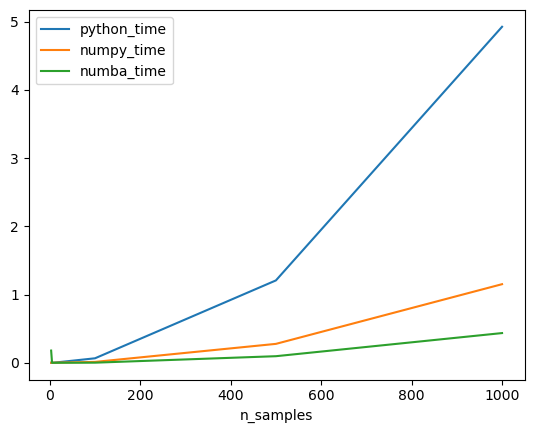

In [37]:
df.plot.line(x='n_samples')

#### Warning, `numba` can be very finicky

For example, numba should not be used with standard Python lists, it works _much_ better with numpy arrays. It does not work with the `yield` keyword. Even if you don't use it explicitely, it is used in some comprehensions.

### What if we pre-compile Python, similar to C? `cython` does exactly that

In [38]:
!pip install Cython # make sure it is installed in the correct enviornment

In [39]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [40]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt

ctypedef np.float64_t DTYPE_t
ctypedef np.int64_t ITYPE_t

def knn_cython(np.ndarray[DTYPE_t, ndim=2] X_train,
               np.ndarray[ITYPE_t, ndim=1] y_train,
               np.ndarray[DTYPE_t, ndim=2] X_test,
               int k):

    cdef int n_test = X_test.shape[0]
    cdef int n_train = X_train.shape[0]
    cdef int n_features = X_train.shape[1]
    cdef np.ndarray[ITYPE_t, ndim=1] predictions = np.empty(n_test, dtype=np.int64)

    cdef int i, j, idx
    cdef double dist
    cdef double diff
    cdef int best_label
    cdef int best_count
    cdef int label

    cdef np.ndarray[double, ndim=1] distances = np.empty(n_train, dtype=np.float64)
    cdef dict label_counts

    for idx in range(n_test):
        # Compute distances
        for i in range(n_train):
            dist = 0.0
            for j in range(n_features):
                diff = X_train[i, j] - X_test[idx, j]
                dist += diff * diff
            distances[i] = sqrt(dist)

        # Sort distances, get sorted indices
        sorted_indices = distances.argsort()

        # Majority vote
        label_counts = {}
        best_label = -1
        best_count = -1
        for i in range(k):
            label = y_train[sorted_indices[i]]
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

            if label_counts[label] > best_count:
                best_label = label
                best_count = label_counts[label]

        predictions[idx] = best_label

    return predictions

In [41]:
%%time
times = []

COLUMNS = 3

for i in [3, 5, 10, 100, 500, 1_000]:
    X_train_np = np.random.rand(i, COLUMNS)
    y_train_np = np.random.randint(0, 5, size=i)  # Labels from 0 to 4
    X_test_np  = np.random.rand(i, COLUMNS)

    X_train = X_train_np.tolist()
    y_train = y_train_np.tolist()
    X_test  = X_test_np.tolist()

    cython_time  = timeit(lambda: knn_cython(X_train_np, y_train_np, X_test_np, k=2), number=10)

    times.append((i, cython_time))

# Pretty-print
df_cython = pd.DataFrame(times, columns=["n_samples", "cython_time"])

CPU times: user 413 ms, sys: 2.46 ms, total: 416 ms
Wall time: 415 ms


In [42]:
df = pd.concat([df, df_cython.cython_time], axis=1)
df

,n_samples,python_time,numpy_time,numba_time,cython_time
0,3,0.000304,0.000594,0.179252,0.000137
1,5,0.000629,0.000902,0.000023,0.000349
2,10,0.002267,0.001463,0.000039,0.000361
3,100,0.065819,0.012920,0.001625,0.002137
4,500,1.207252,0.277192,0.096514,0.076099
5,1000,4.924447,1.151940,0.435415,0.333899


<Axes: xlabel='n_samples'>

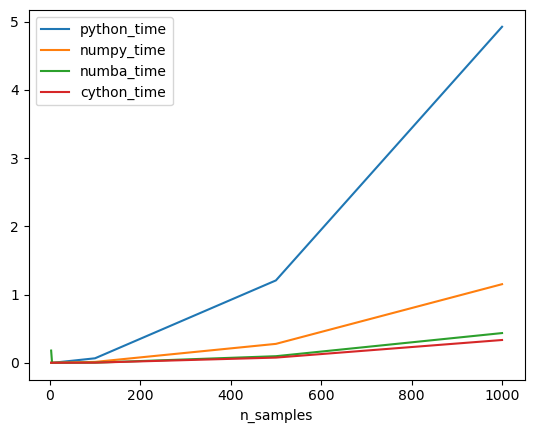

In [43]:
df.plot.line(x='n_samples')